<a href="https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Playing_With_Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
! pip install pandas
! pip install sodapy
! pip install geopy
! pip install numpy
! pip install seaborn
! pip install matplotlib
! apt install proj-bin libproj-dev libgeos-dev
! apt-get install libgeos-3.5.0
! apt-get install libgeos-dev
! pip install https://github.com/matplotlib/basemap/archive/master.zip
! pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
     / 190.8MB 217.5MB/s
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756025 sha256=a3cb821ceb49b40b33d849292316f778bf138648e56dbd258c8f40382253eabe
  Stored in directory: /

# Laboratory 1: Examining New York City (NYC) Fire Incidents

### Team Members: Chase Henderson, Aditya Garapati, Carl Walenciak, Brian Waite


## Business Understanding

### Data General Description: 

The Fire Department of New York City (FDNY) collects data on all incidents handled by non-EMS units including fire, medical and non-fire emergencies. This data is more broadly collected in support of the New York Fire Incident Reporting System (NYFIRS) and the National Fire Incident Reporting System (NFIRS). According to the New York City Open Data platform (https://data.cityofnewyork.us) NFIRS data was originally intended to aid in understanding the nature and causes of fire, civilian fire casualties and firefighter injuries, but has since expanded to collect information on all incidents to which fire units respond. [1]

Although FDNY Incident data is available from 2013 through June, 2018, the total number of records for that period is approximately 2.5 Million and represented a challenge to computing resources available to the team. In order to limit the size of the data set, but still achieve the research objectives, the team downselected the data set to include only fire incident records from the six month period beginning 01-01-2018 at 12AM through 06-30-2018 at midnight. The resultant set contains 240,979 records with 25 original feature columns.

### Data Determined Out of Scope: 

As indicated above, the original FDNY Incident data set contains a variety of incident types including non-fire medical emergencies, gas leaks, support to police activity and wide variety of other events. In order to deliver meaningful analytic outcomes and focus on specific challenge problems, the selected data set includes only fire-related incidents (indicated within the data set as 100-series (1XX) incidents. 

### Supplemental Data: 

In order to enable the team to ask more robust questions of interest of the primary data, we sought additional associated or relevant data to supplement our analysis. This includes: 

* Firebox Location Data: Each incident within the primary data set is linked to a specific firebox. New York City's unique infrastructure includes a series of over 15,000 on-street fireboxes that allow easy access to emergency services. While many of these are in varying states of repair, the FDNY uses them as geographic reference points for the dispatch of units and the records kept in the primary dataset. The team sought and identified geo-reference data to improve the utility of the firebox field in the primary data set. This was obtained from reference [2]. Although this data is somewhat dated -- last updated in 2008 -- the age of the NYC Firebox system and the immobility of the devices makes us confident that the location information is unchanged. Data for 16,284 fireboxes is listed. 

* Firehouse Location Data: The team also sought and identified a complete listing of the name, type, and geo-reference data of all 213 firehouses in the boroughs of NYC. [3]

### Analytic Questions of Interest: 

Using this publicly available data set, the team has identified a number of potential analytic questions of interest that could potentially provide value to FDNY and NYC decision makers regarding the allocation of financial and personnel resources. Specific questions of interest could include: 

* Identification of regions of New York City where fire incidents are most likely to occur. 
* Prediction of the response time and/or total incident duration based on available features. 
* Identify trends within the data set that might indicate increased periods of risk. 

These insights could specifically be used to determine which fire stations should receive additional personnel or equipment resources or design staffing schedules to coincide with the most likely periods of fire related activity. 

Further, this analysis may help to aid in the identification of problem neighborhoods where increased inspection activity or public education campaigns could help to contribute to additional fire prevention measures being deployed in a proactive fashion by city decision makers. 

### Measuring Outcomes from the Data: 

The team believes that this data set can support a variety of analytic methodologies and provide interesting answers to the question of interest above. Techniques available will include both classification and regression based models. In order to ensure validity of results, all evaluations of data will be on a 70/30 train/test split of the data with test data being withheld for final testing and not made available for model improvement at any stage of the analysis. 

Below we describe our evaluative criteria for each type of model anticipated: 

In all cases, our models will be evaluated on whether the findings are logical and representative of reasonable outcomes given the data provided and are consistent with the exploratory data analysis. 

*Linear Regression:* 

Feature selection for inclusion in the model will likely make use of feature down-selection techniques including forward, backward, LASSO or ELASTIC-NET selection techniques with Bayesian Information Criteria, Adjusted R-Squared, and Residual Sum of Squares acting as the primary selection criteria. These criteria will also be used to evaluate the model fit in comparison to the test data set. 

*Classification:*

Evaluation of classification models will be through the use of confusion matrix based statistics including accuracy, sensitivity and specificity. In addition, the Area Under the Curve (AUC) assessments using Receiver Operating Characteristic (ROC) curve analysis will be used to compare model performance and to evaluate the performance of any final selected model. 

In [0]:
# Imports section
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
from sodapy import Socrata
from mpl_toolkits.basemap import Basemap
import missingno as msno
import requests
from google.colab import drive
import datetime as dt

In [63]:
# Data Import From City of New York
# Ignore warning regarding API limitations as that is only regarding programming requests at speed. 

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tm6d-hbzd", limit = 250000)#limit=300000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

#Get the firehouse location information
firehouse_info = client.get("hc8x-tcnd", limit=10000)

firehouse_df = pd.DataFrame.from_records(firehouse_info)
firehouse_df = firehouse_df.dropna()

#Set up Google Drive access to additional data stored there
drive.mount('/content/drive')

#Get the firebox location information
firebox_locs = pd.read_csv("/content/drive/My Drive/Fire Data/Fire Boxes.csv", names=['LONG','LAT','fire_box','nearest_intersection'])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Get the precipitation information for NYC on the dates of interest
precip = pd.read_csv("/content/drive/My Drive/Fire Data/Rain_Snow.csv")
precip['DATE'] = pd.to_datetime(precip['DATE'])

In [0]:
#convert dates to date time objects
results_df['arrival_date_time']=pd.to_datetime(results_df['arrival_date_time'])
results_df['incident_date_time']=pd.to_datetime(results_df['incident_date_time'])
results_df['last_unit_cleared_date_time']=pd.to_datetime(results_df['last_unit_cleared_date_time'])

In [0]:
#Limit results to the most recent 1 year time frame available -- July 2017 through June 2018
results_df = results_df[results_df['incident_date_time'] > pd.to_datetime('2017-07-01 00:00:00')]

#Calculate new feature "response_time" that is the arrival time of units on scene minus the time the incident occured. 
#Convert to a numeric type and convert units to minutes. 
results_df['response_time'] = (results_df['arrival_date_time'] - results_df['incident_date_time'])
results_df['response_time'] = pd.to_numeric(results_df['response_time'])
results_df['response_time'] = results_df['response_time']/ 60000000000

#Convert other data elements to the proper type
results_df['units_onscene'] = pd.to_numeric(results_df['units_onscene'])
results_df['total_incident_duration'] = pd.to_numeric(results_df['total_incident_duration'])
results_df['story_fire_origin_count'] = pd.to_numeric(results_df['story_fire_origin_count'])
results_df['fire_box'] = results_df['fire_box'].astype('str')

#Convert firehouse values
firehouse_df['latitude'] = pd.to_numeric(firehouse_df['latitude'])
firehouse_df['longitude'] = pd.to_numeric(firehouse_df['longitude'])


In [0]:
#Add the borough code to the firebox column to enable merging with the firebox location data set
results_df.loc[results_df['borough_desc'].str.match('1 - Manhattan'), 'fire_box'] = 'M' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('2 - Bronx'), 'fire_box'] = 'X' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('3 - Staten Island'), 'fire_box'] = 'R' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('4 - Brooklyn'), 'fire_box'] = 'B' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('5 - Queens'), 'fire_box'] = 'Q' + results_df.fire_box

In [0]:
#Merge the fire_box dataframe with the overall dataframe
final_df = pd.merge(results_df, firebox_locs, on = 'fire_box')
final_df['LAT'] = pd.to_numeric(final_df['LAT'])
final_df['LONG'] = pd.to_numeric(final_df['LONG'])

In [0]:
# #Uncomment to run this code, but takes multiple hours to calculate distance for each point. 
# #Get the nearest fire station
# #This code takes a long time to run because it needs to calculate the distance for each firebox to all fire stations and then select the minimum.
# final_df['Distance_To_Nearest_Station'] = 0
# i = 0
# for lat, long in zip (final_df.LAT, final_df.LONG): 
#     dist = findNearestFirestation(lat,long)
#     final_df['Distance_To_Nearest_Station'].iloc[i] = dist
#     i = i + 1

In [0]:
#All code above this line is to create the initial data set. Due to size and the time required to generate the "Distance_To_Nearest_Station" feature, we have run and stored the data file 
#of line in a "pickle" file to enable rapid analysis by the team. This file is read in here and retains all of the data type associations generated above. 

final_df = pd.read_pickle('/content/drive/My Drive/Fire Data/fireData_July17.pkl')

In [0]:
#Drop the unnecessary precip data
precip.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION'], axis=1, inplace=True)

#Pull out the date to support merge
final_df['DATE'] = final_df.apply (lambda row: row['incident_date_time'].date(), axis=1)

#Some magical required type conversion
final_df['DATE'] = pd.to_datetime(final_df['DATE'])
precip['DATE'] = pd.to_datetime(precip['DATE'])

#Merge the precipitation data with the final data frame
final_df = pd.merge(final_df, precip, on = 'DATE')

In [72]:
final_df.head()

,im_incident_key,fire_box,incident_type_desc,incident_date_time,arrival_date_time,units_onscene,last_unit_cleared_date_time,highest_level_desc,total_incident_duration,action_taken1_desc,action_taken2_desc,action_taken3_desc,property_use_desc,street_highway,zip_code,borough_desc,floor,co_detector_present_desc,story_fire_origin_count,fire_spread_desc,detector_presence_desc,aes_presence_desc,standpipe_sys_present_flag,fire_origin_below_grade_flag,response_time,LONG,LAT,nearest_intersection,Distance_To_Nearest_Station,DATE,PRCP,SNOW,SNWD
0,63476768,X2928,"746 - Carbon monoxide detector activation, no CO",2018-06-30 23:55:29,2018-07-01 00:00:32,2.0,2018-07-01 00:22:57,11 - First Alarm,1648.0,"42 - HazMat detection, monitoring, sampling, &...",51 - Ventilate,86 - Investigate,429 - Multifamily dwelling,UNDERCLIFF AVE,10453,2 - Bronx,1,Yes,NaN,NaN,NaN,NaN,NaN,NaN,5.050000,-73.922135,40.849047,Undercliff Ave & W 175th St,0.453190,2018-06-30,0.0,0.0,0.0
1,63476763,B1021,"300 - Rescue, EMS incident, other",2018-06-30 23:54:44,2018-06-30 23:58:59,1.0,2018-07-01 00:09:29,11 - First Alarm,885.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,RUTLAND RD,11203,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.250000,-73.931290,40.660580,Utica Ave & Rutland Rd,0.687401,2018-06-30,0.0,0.0,0.0
2,63476761,X2745,"651 - Smoke scare, odor of smoke",2018-06-30 23:54:13,2018-06-30 23:58:29,3.0,2018-07-01 00:07:50,11 - First Alarm,817.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,PROSPECT AVE,10456,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.266667,-73.896640,40.833120,Prospect Ave & E 170th St,0.285027,2018-06-30,0.0,0.0,0.0
3,63476762,X2135,"117 - Commercial Compactor fire, confined to r...",2018-06-30 23:54:08,2018-06-30 23:58:53,5.0,2018-07-01 00:19:16,11 - First Alarm,1508.0,11 - Extinguishment by fire service personnel,51 - Ventilate,NaN,429 - Multifamily dwelling,BROWN PL,10454,2 - Bronx,basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.750000,-73.921070,40.806590,Brown Pl & E 136th St,0.449370,2018-06-30,0.0,0.0,0.0
4,63476759,B1877,"710 - Malicious, mischievous false call, other",2018-06-30 23:53:33,2018-06-30 23:56:50,1.0,2018-06-30 23:57:11,11 - First Alarm,218.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,DEFAULT RECORD FOR SF,11208,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.283333,-73.861320,40.671160,Dumont Ave & Drew St,0.253279,2018-06-30,0.0,0.0,0.0


## You can start putting analysis code here for now. The final_df exists at this point for the most part. 

## Downsample By Carl

In [0]:
#Set up to downsample by borough, by month. 
final_df['incident_month'] = final_df['incident_date_time'].dt.month
boroughs = final_df['borough_desc'].unique()
months = final_df['incident_month'].unique()

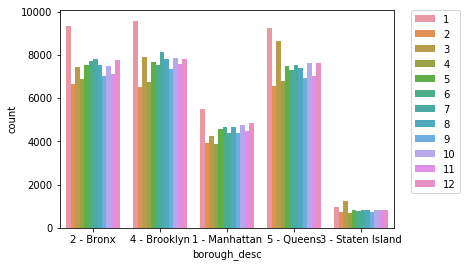

In [74]:
#Event count distribution prior to sampling
sns.countplot(x="borough_desc", hue='incident_month', data=final_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [0]:


sample_size = 50000
sampled_df = pd.DataFrame()

for i in boroughs:
    #Filter to Borough
    temp_df = final_df[final_df['borough_desc'] == i]
    
    for x in months:
        #Filter to Month
        temp_df2 = temp_df[temp_df['incident_month'] == x]
        
        #Get Proportional Sample Size
        num_of_samples = sample_size * (temp_df2.shape[0]/final_df.shape[0])
        
        #Sample Data
        temp_sampled = temp_df2.sample(n = round(num_of_samples), random_state = 123)
        
        #Assign to Dataframe
        sampled_df = pd.concat([sampled_df, temp_sampled])
        
#store the sampled dataframe back as final_df
final_df = sampled_df

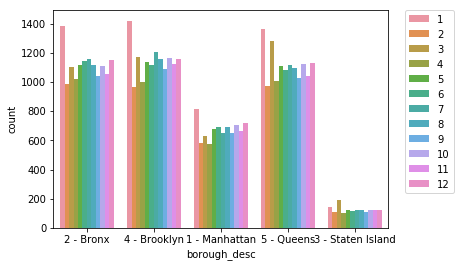

In [76]:
#Event count distribution after sampling
sns.countplot(x="borough_desc", hue='incident_month', data=final_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Additional Cleaning By Carl

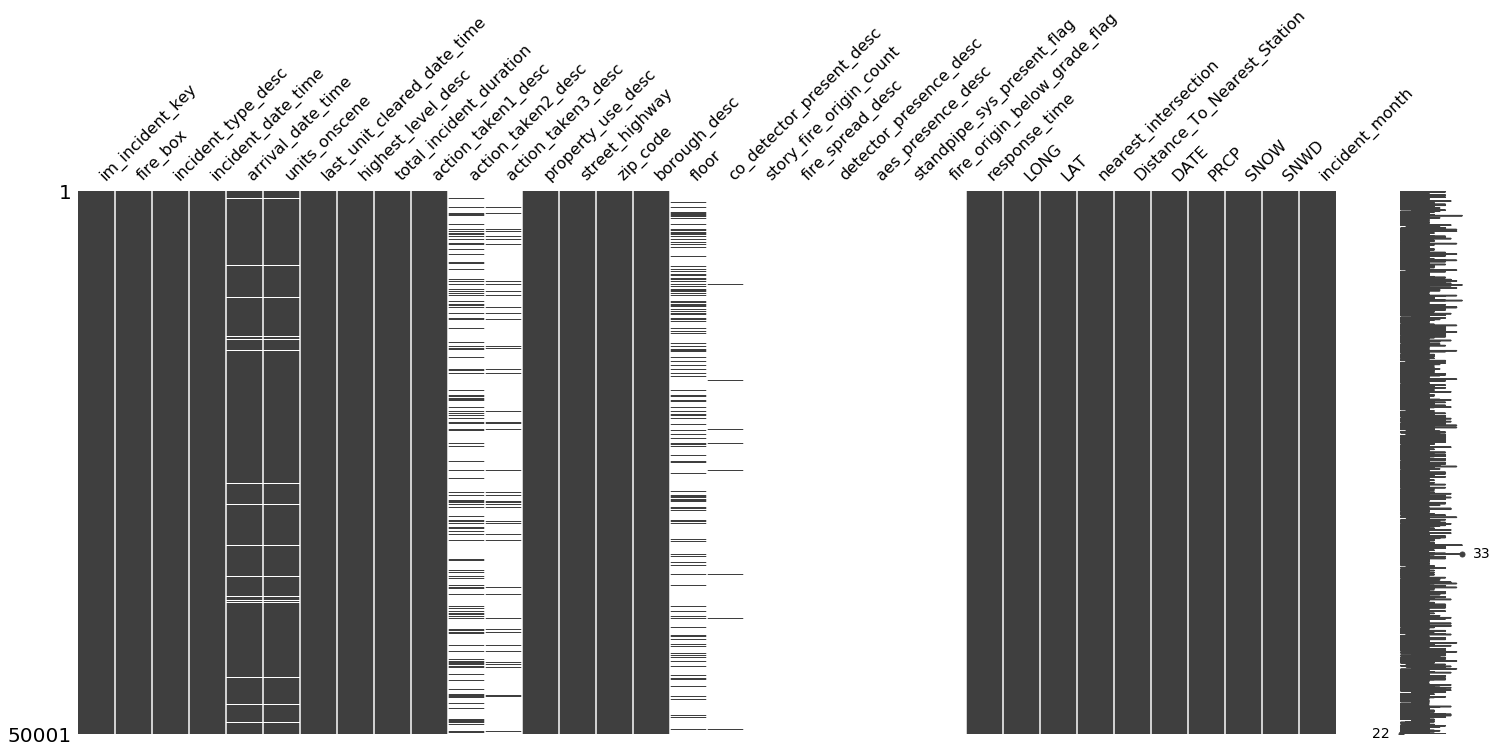

In [77]:
msno.matrix(final_df)

In [0]:
#Drop the cells with missing values that we are choosing not to impute
drop_cols =[  'aes_presence_desc'
            , 'action_taken2_desc'
            , 'action_taken3_desc'
            , 'arrival_date_time'
            , 'co_detector_present_desc'
            , 'detector_presence_desc'
            , 'fire_origin_below_grade_flag'
            , 'fire_spread_desc'
            , 'standpipe_sys_present_flag'
            , 'story_fire_origin_count'
           ]

final_df = final_df.drop(drop_cols, axis = 1)

# Brian Question: Did we really want to drop arrival_date_time or just get rid of the rows where that was missing? 

## Impute Missing Variables

### Units Onscene Impute

In [0]:
# Create On Scene Cross Reference
filter_to = final_df['units_onscene'].isnull()== False
xref_units_onscene = final_df[filter_to][['borough_desc','incident_type_desc', 'units_onscene']]
xref_units_onscene = xref_units_onscene.rename(columns = {"units_onscene":"onscene_mean"})
xref_units_onscene = pd.DataFrame(xref_units_onscene.groupby('incident_type_desc').mean())

In [0]:
# Merge Data with Mean XRef
final_df = final_df.merge(xref_units_onscene, how = 'left', on = 'incident_type_desc', indicator = True)

In [0]:
# Set On Scene to XXXXX where Null
filter_to = final_df['units_onscene'].isnull()
final_df.loc[filter_to, 'units_onscene'] = final_df[filter_to]['onscene_mean']

In [0]:
final_df = final_df.drop(['onscene_mean', '_merge'], axis = 1)

### Arrival Time Impute

In [0]:
# Create On Scene Cross Reference
filter_to = final_df['response_time'] > 0
xref_resp_time = final_df[filter_to][['borough_desc', 'response_time']]
xref_resp_time = xref_resp_time.rename(columns = {"response_time":"resp_time_mean"})
xref_resp_time = pd.DataFrame(xref_resp_time.groupby('borough_desc').mean())

In [0]:
# Merge Data with Mean XRef
final_df = final_df.merge(xref_resp_time, how = 'left', on = 'borough_desc', indicator = True)

In [0]:
# Set On Scene to XXXXX where Null
filter_to = final_df['response_time'] <= 0
final_df.loc[filter_to, 'response_time'] = final_df[filter_to]['resp_time_mean']

In [0]:
final_df = final_df.drop(['resp_time_mean', '_merge'], axis = 1)

## Missing Values After Imputation and Drops

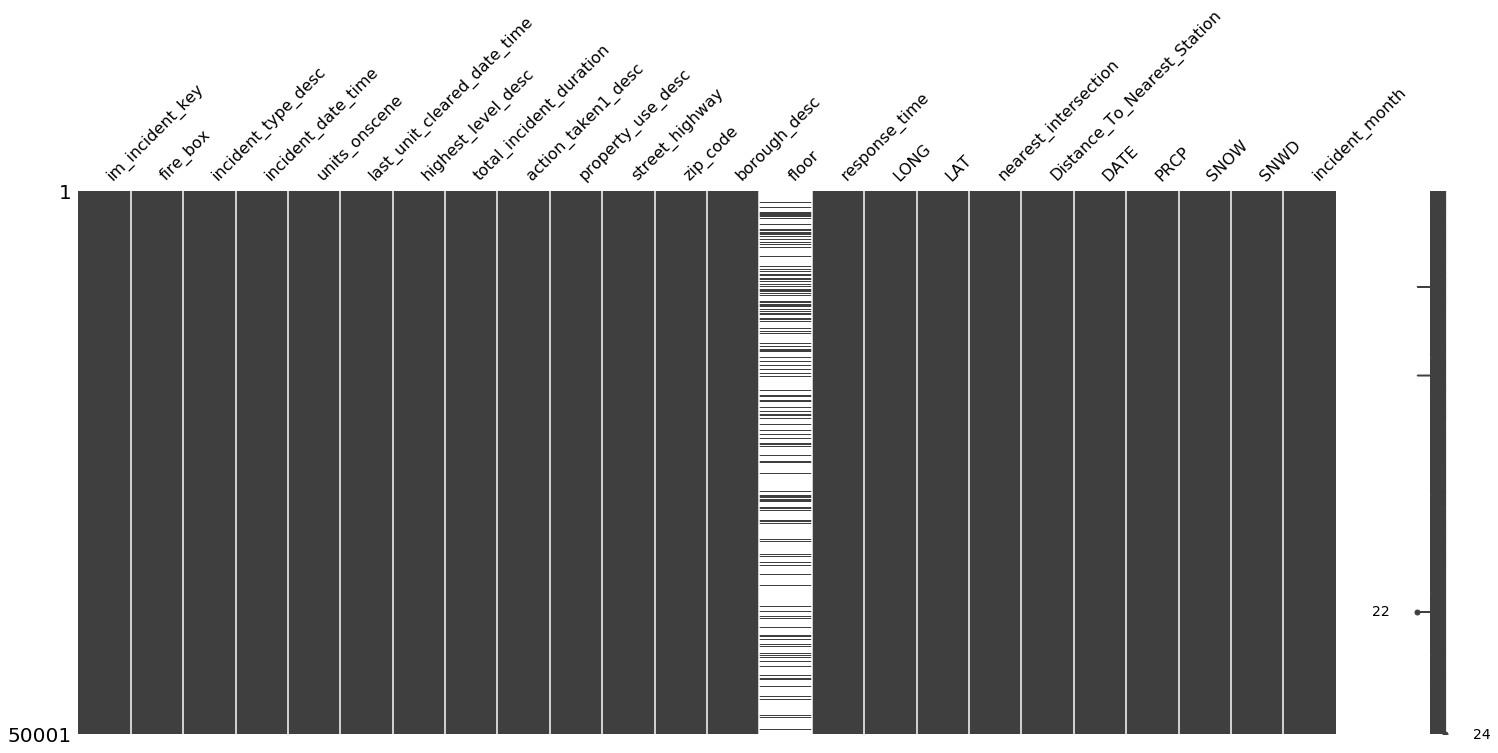

In [87]:
msno.matrix(final_df)

## Additional Exploratory Analysis

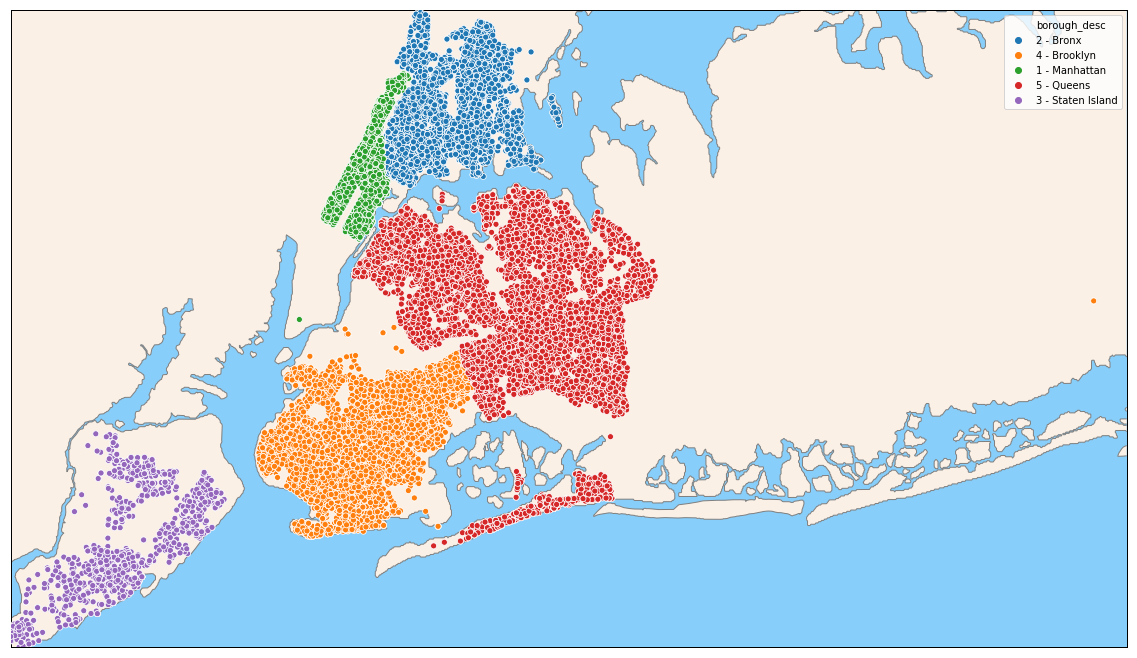

In [88]:
#Generate a plot of the incidents in the data set by borough
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='tmerc',area_thresh = 0.1, resolution='f', llcrnrlon = final_df.LONG.min(), llcrnrlat = final_df.LAT.min(),
urcrnrlon = final_df.LONG.max()+.03, urcrnrlat = final_df.LAT.max(), lat_0 = final_df.LAT.mean(), lon_0 = final_df.LONG.mean())
m.drawmapboundary(fill_color='lightskyblue')
m.fillcontinents(color='linen',lake_color='lightskyblue')
m.drawcoastlines(color='gray')
m.drawrivers(color='lightskyblue')
#Fill the globe with a blue color 

#Fill the continents with the land color

#Include this for the building footprint map
#m.readshapefile(shpfile, 'metro', linewidth=.15)
x, y = m(final_df.LONG.tolist(), final_df.LAT.tolist())
sns.scatterplot(x,y, hue = final_df.borough_desc, zorder = 15)

plt.show()

In [0]:
##Begin Aditya's Code

def groupByBurough_dwelling (df):
   grouped = df.groupby('borough_desc')
   for name,group in df.groupby('borough_desc'):
               plt.figure(name)
               sns.countplot(y="property_use_desc",data=group,order=group.property_use_desc.value_counts().iloc[:5].index).set_title(name)
   return

from datetime import datetime

def groupByBurough_callTime (df):
   for name,group in df.groupby('borough_desc'):
       print(name)
       df2=group.set_index('arrival_date_time')
       ts_df=df2.loc[df2.index.notnull()]
       ts_df.index = pd.to_datetime(ts_df.index)
       ts_df['hour_of_call'] = ts_df.index.hour
       plt.figure(name)
       sns.countplot(x="hour_of_call",data=ts_df).set_title(name)
   return

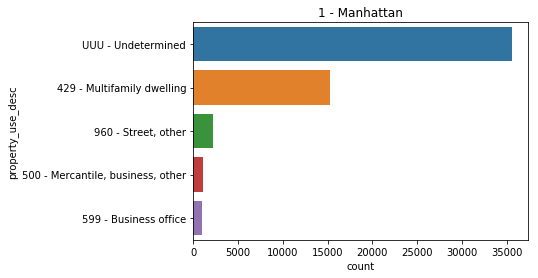

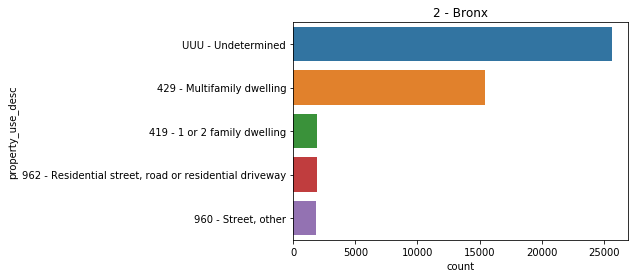

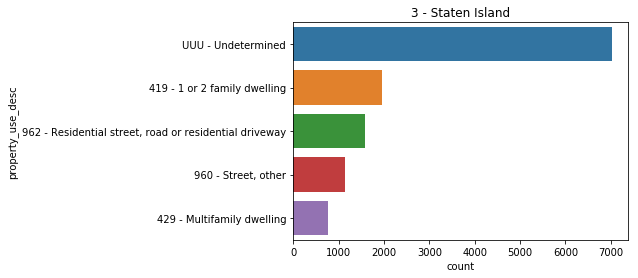

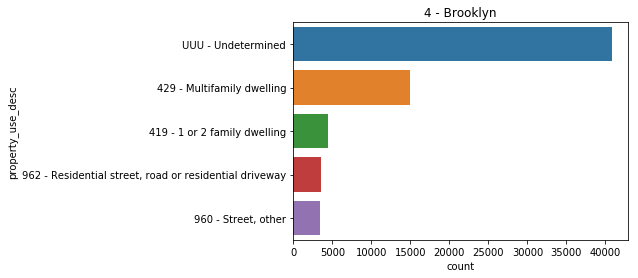

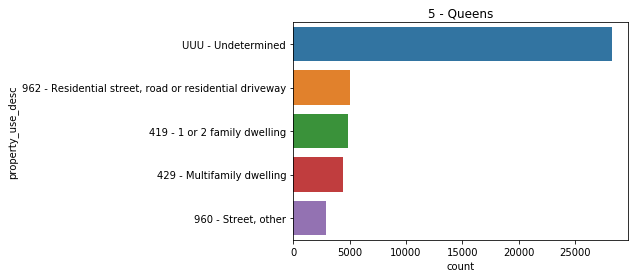

In [90]:
groupByBurough_dwelling(results_df)

## References: 

[1] @ELECTRONIC{firedata,
  author = {Fire Department of New York City (FDNY)},
  year = {2019},
  title = {Incidents Responded to by Fire Companies},
  language = {English},
  howpublished = {\url=https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd},
  owner = {NYC Open Data},
  timestamp = {2019.03.21}
}

[2] @ELECTRONIC{fireboxdata,
  author = {www.poi-factory.com)},
  year = {2008},
  title = {FDNY Firebox Locator Data},
  language = {English},
  howpublished = {\url=http://www.poi-factory.com/node/11074},
  owner = {POI Factory},
  timestamp = {2008.02.26}
}

[3] @ELECTRONIC{firehousedata,
  author = {Fire Department of New York City (FDNY))},
  year = {2018},
  title = {FDNY Firehouse Listing},
  language = {English},
  howpublished = {\url=https://data.cityofnewyork.us/Public-Safety/FDNY-Firehouse-Listing/hc8x-tcnd},
  owner = {NYC Open Data},
  timestamp = {2018.09.10}
}